# Finetuning and Bayesian Adaptation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

import statsmodels.formula.api as smf

import torch

In [2]:
from change_detection import RateFunctionTest, ScoreTest

from cgf_network import CGF_ICNN, ConditionalCGF
from models.simple_examples import Basic_MNIST
from models.data_utilities import exact_data_ratios


from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from functools import partial

# model checkpoints
classifier_ckpt = './learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'
conditional_ckpt = 'trainedParameters/MNIST_initial/step2_MNIST/validation-epoch=128-step=8062500.ckpt'



# load MNIST data 
mnist_train_data = MNIST('~/Datasets/', download=True, train=True,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )

mnist_test_data = MNIST('~/Datasets/', download=True, train=False,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )


mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
train_like, _ = exact_data_ratios(mnist_train_data)
mnist_model.fit_activity_transform(train_like)

activity_dataset_train = mnist_model.internal_activity_dataset(train_like)
activity_dataset_test = mnist_model.internal_activity_dataset(mnist_test_data)


mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_dataset_train[:][0])
conditional_mnist = ConditionalCGF.load_from_checkpoint(conditional_ckpt,
                                                        dataset_to_model=activity_dataset_train)


## Finetuning weights for changes that are detected.

We need a test to condition on positive detections.

In [3]:
rate_test = RateFunctionTest(mnist_cgf, 100, 0.95)

[-inf, inf] [-inf, inf]
[-inf, 1] [-inf, 1.0]
[-inf, 1] [-inf, 1.0]
[-inf, 0.25] [-inf, 0.9933833677322135]
[0.125, 0.25] [0.35206358906047464, 0.9933833677322135]
[0.1875, 0.25] [0.8659406152089395, 0.9933833677322135]
[0.1875, 0.21875] [0.8659406152089395, 0.9660234845848249]
[0.203125, 0.21875] [0.9284853530056782, 0.9660234845848249]
[0.2109375, 0.21875] [0.9462706601148589, 0.9660234845848249]
[0.2109375, 0.21484375] [0.9462706601148589, 0.9591985859435457]


In [4]:
def sample_activity(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]
    

    return activity, targets


In [248]:
distributions = []

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 2
alt_weights[8] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[0] = 1.5
alt_weights[1] = 1.5
alt_weights[2] = 1.5
alt_weights[3] = 1.5
alt_weights[4] = 1.5

distributions.append(alt_weights)


## Initial pass: looking for differences in weights

In [88]:
activity, targets = sample_activity(activity_dataset_test, 100, 200, distributions[0])

In [91]:
rate_test.is_different(activity[2])

tensor([True])

In [92]:
mu = activity[2].mean(0)
theta = mnist_cgf.inv_jac(mu[None, :])

In [130]:
def exponential_tilt_weights(xs, theta, CGF):
    """ makes the weights for exponential tilting based on the new theta value  """
    return torch.exp(xs @ theta.T - CGF.fwd_cpu(theta))

    

In [131]:
T, target = activity_dataset_train[:]
weight = exponential_tilt_weights(T, theta, mnist_cgf).squeeze().detach()

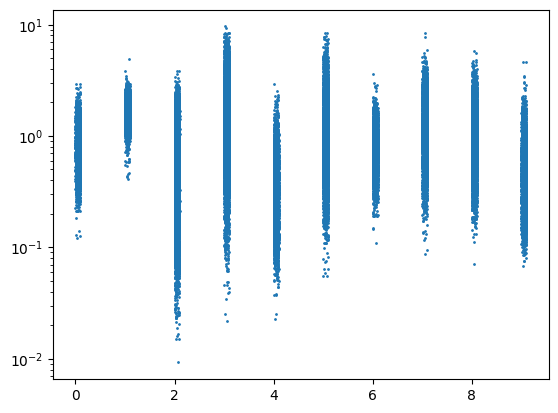

In [135]:
plt.scatter(target + 0.1*torch.rand(target.shape[0]), weight, s=1)
plt.yscale('log')

In [136]:
means = []
stds = []

for i in range(10):
    means.append( weight[target == i].mean())
    stds.append( weight[target == i].var()**0.5)

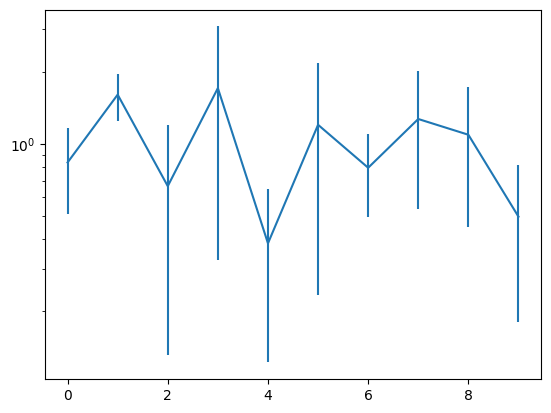

In [137]:
plt.errorbar( range(10), means, yerr = stds)
plt.yscale('log')

In [142]:
thetas = []
for i in range(activity.shape[0]):
    print(i)
    if rate_test.is_different(activity[i]):
        mu = activity[i].mean(0)
        theta = mnist_cgf.inv_jac(mu[None, :])
        thetas.append(theta)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [143]:
len(thetas)

101

In [161]:
means = torch.zeros(len(thetas), 10)
stds = torch.zeros(len(thetas), 10)

sums = torch.zeros(len(thetas), 10)
squares = torch.zeros(len(thetas), 10)

for j, theta in enumerate(thetas):
    weight = exponential_tilt_weights(T, theta, mnist_cgf).squeeze().detach()
    for i in range(10):
        means[j, i] =  weight[target == i].mean()
        stds[j, i] = weight[target == i].var()**0.5

<ErrorbarContainer object of 3 artists>

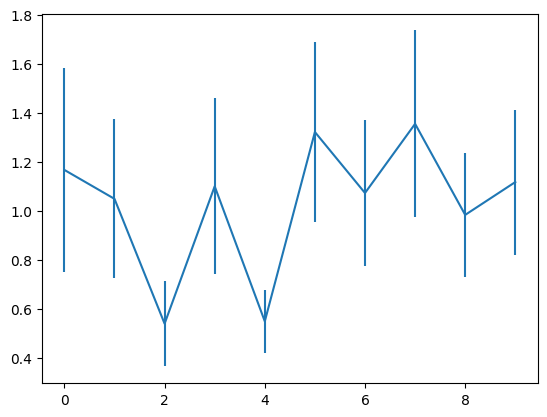

In [162]:
means.mean(0)
stds_bin = means.var(0)**0.5 + (stds**2).mean(0)**0.5 / len(thetas)

plt.errorbar(range(10), means.mean(0), stds_bin)


In [172]:
weights = {i:[] for i in range(10)}

for j, theta in enumerate(thetas):
    weight = exponential_tilt_weights(T, theta, mnist_cgf).squeeze().detach()
    for i in range(10):
        weights[i].append( weight[target == i])

means, stds = torch.zeros(10), torch.zeros(10)
for i in range(10):
    all_weights = torch.concat(weights[i])
    means[i] = all_weights.mean()
    stds[i] = all_weights.var()**0.5

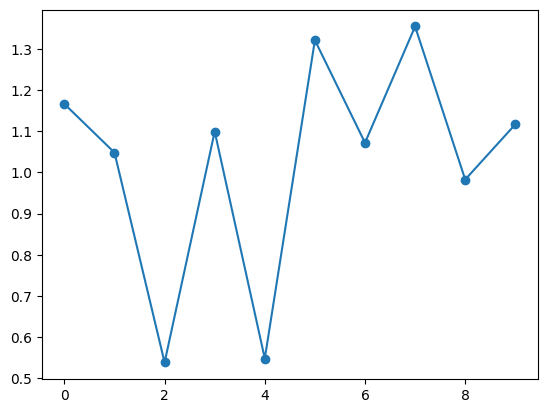

In [176]:
plt.plot(range(10), means, '-o')

## Wrapping this up into a single function

In [37]:
# important functions
def exponential_tilt_weights(xs, theta, CGF):
    """ makes the weights for exponential tilting based on the new theta value  """
    return torch.exp(xs @ theta.T - CGF.fwd_cpu(theta))


def mean_weights(n_mean, rate_test, distribution, n_samples=200 ):
    activity, _ = sample_activity(activity_dataset_test, n_mean, n_samples, distributions[0])
    T, target = activity_dataset_train[:]
    
    thetas = []
    for i in range(activity.shape[0]):
        print(i)
        if rate_test.is_different(activity[i]):
            mu = activity[i].mean(0)
            theta = mnist_cgf.inv_jac(mu[None, :])
            thetas.append(theta)

    weights = {i:[] for i in range(10)}

    # slow. Not enough 
    for j, theta in enumerate(thetas):
        weight = exponential_tilt_weights(T, theta, mnist_cgf).squeeze().detach()
        for i in range(10):
            weights[i].append( weight[target == i])
    
    means, stds = torch.zeros(10), torch.zeros(10)
    for i in range(10):
        all_weights = torch.concat(weights[i])
        means[i] = all_weights.mean()
        stds[i] = all_weights.var()**0.5

    return means, stds


In [38]:
means, stds = mean_weights(100, rate_test, distributions[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


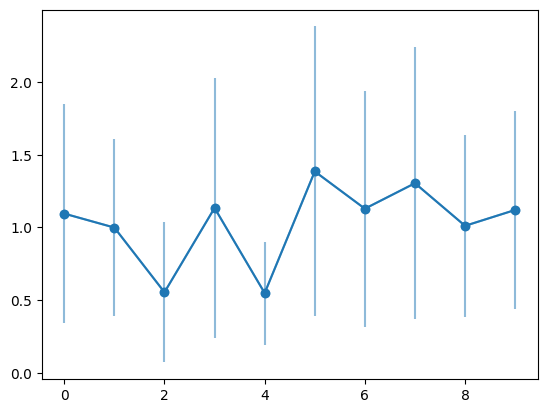

In [39]:
plt.errorbar(range(10), means, fmt='-o', yerr=stds, alpha=0.5)
plt.plot(range(10), means, '-oC0')

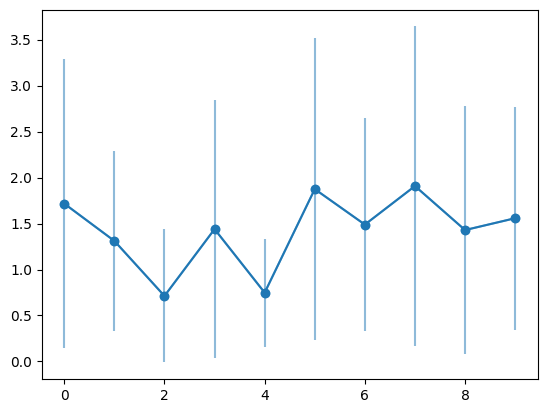

In [35]:
plt.errorbar(range(10), means, fmt='-o', yerr=stds, alpha=0.5)
plt.plot(range(10), means, '-oC0')
plt.xlabel('

## Bayesian change detection and adaptation

### Change detection: evaluate the model posterior.

In [3]:
from change_detection import RateFunctionTest, ScoreTest

from cgf_network import CGF_ICNN, ConditionalCGF
from models.simple_examples import Basic_MNIST
from models.data_utilities import exact_data_ratios


from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from functools import partial

# model checkpoints
classifier_ckpt = './learnedExpFam/4ttqob80/checkpoints/epoch=48-step=82712.ckpt'
CGF_ckpt = 'trainedParameters/MNIST_initial/step1_MNIST/validation-epoch=310-step=2308242.ckpt'
conditional_ckpt = 'trainedParameters/MNIST_initial/step2_MNIST/validation-epoch=128-step=8062500.ckpt'



# load MNIST data 
mnist_model = Basic_MNIST.load_from_checkpoint(classifier_ckpt)
mnist_model.setup()
mnist_model.fit_activity_transform(mnist_model.data_train)

activity_dataset_train = mnist_model.internal_activity_dataset(mnist_model.data_train)


mnist_test_data = MNIST('~/Datasets/', download=True, train=False,
                        transform=Compose(
                          [ToTensor(), Normalize(0., 1.),
                           partial(torch.reshape, shape=(-1,))
                           ])
                       )
activity_dataset_test = mnist_model.internal_activity_dataset(mnist_test_data)


mnist_cgf = CGF_ICNN.load_from_checkpoint(CGF_ckpt, data_to_model=activity_dataset_train[:][0])
conditional_mnist = ConditionalCGF.load_from_checkpoint(conditional_ckpt,
                                                        dataset_to_model=activity_dataset_train,
                                                       numsamples=1000)
conditional_mnist.setup()

setup called


In [38]:
distributions = []

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 0
alt_weights[4] = 0
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[2] = 2
alt_weights[9] = 2
alt_weights[8] = 2
distributions.append(alt_weights)

alt_weights={i:1. for i in range(10)}
alt_weights[0] = 1.5
alt_weights[1] = 1.5
alt_weights[2] = 1.5
alt_weights[3] = 1.5
alt_weights[4] = 1.5

distributions.append(alt_weights)

In [4]:
inputs = conditional_mnist.data 

In [5]:
parameters = conditional_mnist.make_parameters(torch.arange(10))
input_projection = inputs @ parameters.T

In [6]:
def exponential_tilt_weights(xs, theta, CGF):
    """ makes the weights for exponential tilting based on the new theta value  """
    return torch.exp(xs @ theta.T - CGF.fwd_cpu(theta))

In [7]:
input_projection.shape

torch.Size([54000, 10])

In [8]:
conditional_mnist.fwd_cpu(parameters)

tensor([[21.6339],
        [16.5894],
        [11.4382],
        [13.0264],
        [23.0455],
        [13.4511],
        [22.6325],
        [18.7629],
        [15.1288],
        [19.9964]], grad_fn=<ToCopyBackward0>)

In [10]:
def sample_activity(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]
    

    return activity, targets

In [11]:
activity, targets = sample_activity(activity_dataset_test, 100, 200)

In [12]:
log_posterior = (activity @ parameters.T) - conditional_mnist.fwd_cpu(parameters).T - 0.1*torch.ones(10)

In [13]:
posterior = torch.nn.functional.softmax(log_posterior.mean(1), dim=1)

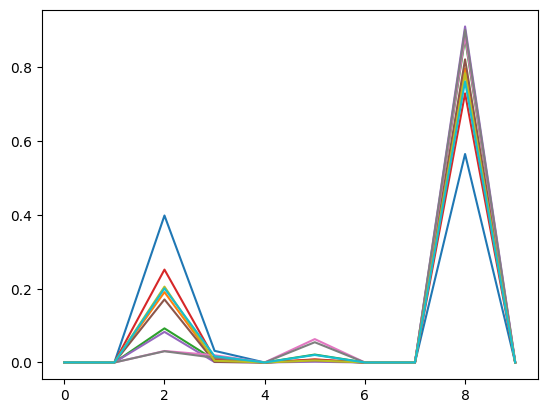

In [14]:
for i in range(10):
    plt.plot(posterior[i].detach())

It seems like Bayesian change detection by evaluating the posterior distribution does not work very well.

In [15]:
activity, targets = sample_activity(activity_dataset_train, 100, 200)

In [16]:
log_posterior = (activity @ parameters.T) - conditional_mnist.fwd_cpu(parameters).T + np.log(0.1)*torch.ones(10)

In [17]:
posterior = torch.nn.functional.softmax(log_posterior.mean(1), dim=1)

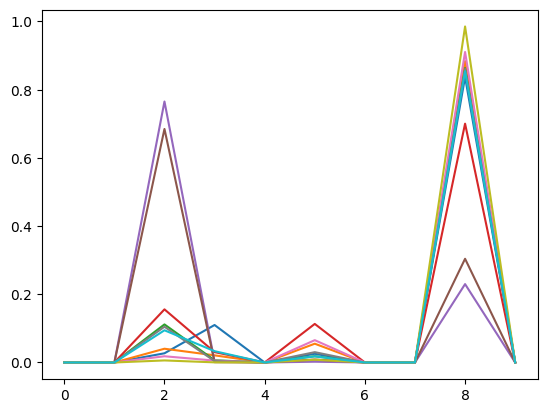

In [18]:
for i in range(10):
    plt.plot(posterior[i].detach())

What if we crank up the weight on the prior?

In [19]:
activity.shape

torch.Size([200, 100, 28])

In [20]:
log_posterior = (activity.mean(1) @ parameters.T) - conditional_mnist.fwd_cpu(parameters).T + 0.01*np.log(0.1)*torch.ones(10)
posterior = torch.nn.functional.softmax(log_posterior, dim=1)

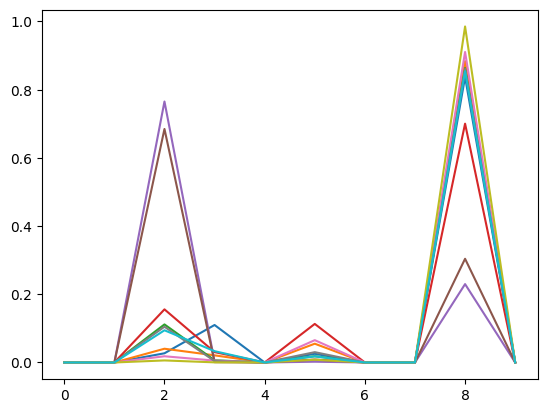

In [21]:
for i in range(10):
    plt.plot(posterior[i].detach())

The constant prior is acting like a simple normalization factor, and therefore gets removed by the softmax.

In [22]:
means = conditional_mnist.jac(parameters)

In [23]:
means.shape

torch.Size([10, 28])

In [24]:
full_mean = means.mean(0)

In [25]:
full_mean @ parameters.T - conditional_mnist.fwd_cpu(parameters).squeeze()

tensor([ -6.8967, -11.7176,   2.2545,   0.1839,  -8.2806,   1.0970,  -9.6810,
         -9.7207,   4.6863,  -6.0096], grad_fn=<SubBackward0>)

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_60770/415569680.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(sm(full_mean @ parameters.T - conditional_mnist.fwd_cpu(parameters).squeeze()).detach())


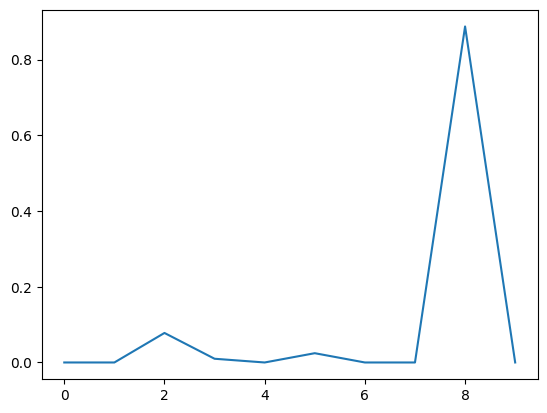

In [26]:
sm = torch.nn.functional.softmax
plt.plot(sm(full_mean @ parameters.T - conditional_mnist.fwd_cpu(parameters).squeeze()).detach())

This should produce a constant value: it is the implicit prior that is encoded by the conditional network. Instead, it produces a deviation exactly like we see in the posteriors.
Perhaps we can enforce this during train time. For now, I'll write it up as is.

## Back to the linear regression approach

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
def sample_means(dataset, N_mean, num_samples, target_weights={i:1. for i in range(10)}):
    """ Sample the average of N_mean activity values
        target_weights are the relative probabilities of different targets
    """
    possible_inds =  len(dataset)

    _, all_targets = dataset[:]
    probs = np.fromiter(map(lambda x: target_weights[x.item()], all_targets), dtype=float)
    probs = probs / sum(probs)
    
    indices = np.random.choice(possible_inds, (num_samples, N_mean), p=probs)
    activity, targets = dataset[indices]
    

    return activity.mean(1), targets

In [54]:
parameters = conditional_mnist.make_parameters(torch.arange(10))
conditional_means = conditional_mnist.jac(parameters).detach()

means, t = sample_means(activity_dataset_test, 100, 200)

In [55]:
l = LinearRegression(fit_intercept=False, positive=True)

In [56]:
l.fit(conditional_means.T, means[2])

LinearRegression(fit_intercept=False, positive=True)

In [57]:
l.coef_

array([0.0749023 , 0.04691891, 0.06058171, 0.1357971 , 0.12072143,
       0.00147762, 0.28060603, 0.09840415, 0.16209143, 0.03704524])

In [58]:
priors = torch.zeros(200, 10)

for i in range(200):
    l = LinearRegression(fit_intercept=False, positive=True)
    l.fit(conditional_means.T, means[i])
    priors[i] = torch.as_tensor(l.coef_ / sum(l.coef_))

In [59]:
priors.mean(0)

tensor([0.0927, 0.0817, 0.0901, 0.1206, 0.0941, 0.0773, 0.1265, 0.1165, 0.0973,
        0.1034])

([<matplotlib.axis.YTick at 0x333102630>,
 [Text(0, 0.0, '0.0'), Text(0, 0.2, '0.2')])

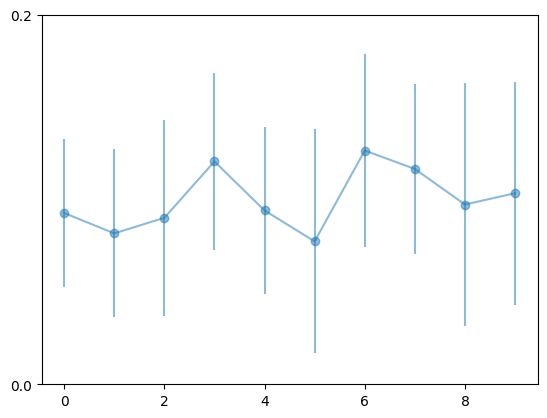

In [60]:
plt.errorbar(range(10), priors.mean(0), fmt='-o', yerr=priors.std(0), alpha=0.5)
plt.ylim([0,0.2])
plt.yticks([0,0.2])

As a function

In [61]:
def prior_regression( N_mean, distribution):
    means, t = sample_means(activity_dataset_test, N_mean, 200, distribution)

    parameters = conditional_mnist.make_parameters(torch.arange(10))
    conditional_means = conditional_mnist.jac(parameters).detach()

    priors = torch.zeros(200, 10)
    
    for i in range(200):
        l = LinearRegression(fit_intercept=False, positive=True)
        l.fit(conditional_means.T, means[i])
        priors[i] = torch.as_tensor(l.coef_ / sum(l.coef_))

    return priors.mean(0), priors.var(0)**0.5

([<matplotlib.axis.YTick at 0x3331b7590>,
 [Text(0, 0.0, '0.0'), Text(0, 0.2, '0.2')])

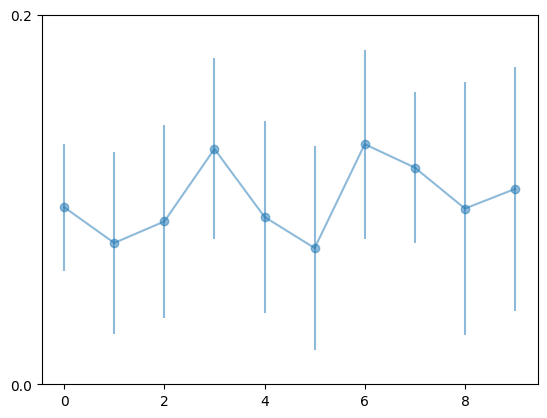

In [62]:
baseline={i:1. for i in range(10)}

m0, v0 = prior_regression(100, baseline)
plt.errorbar(range(10), m0, fmt='-o', yerr=v0, alpha=0.5)
plt.ylim([0,0.2])
plt.yticks([0,0.2])

([<matplotlib.axis.YTick at 0x329c72fc0>,
 [Text(0, 0.0, '0.0'), Text(0, 0.2, '0.2')])

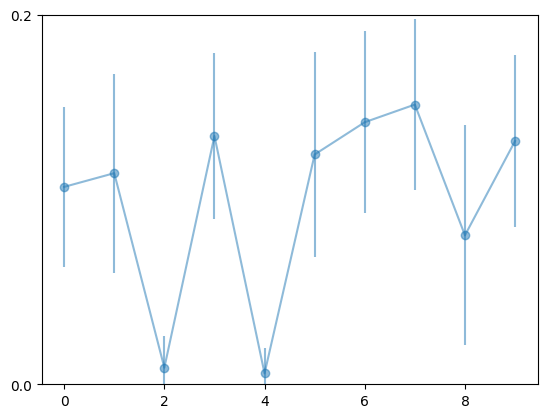

In [63]:
m0, v0 = prior_regression(100, distributions[0])
plt.errorbar(range(10), m0, fmt='-o', yerr=v0, alpha=0.5)
plt.ylim([0,0.2])
plt.yticks([0,0.2])

([<matplotlib.axis.YTick at 0x32d045ee0>,
 [Text(0, 0.0, '0.0'), Text(0, 0.2, '0.2')])

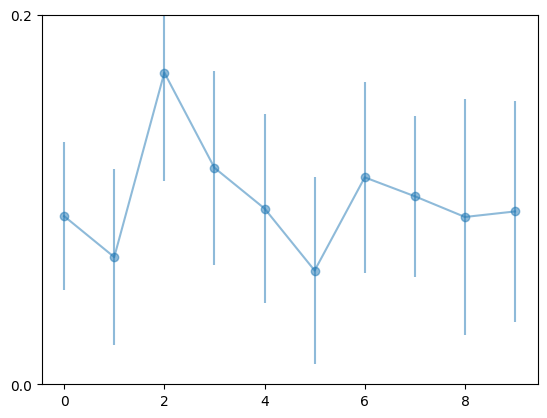

In [64]:
m0, v0 = prior_regression(100, distributions[1])
plt.errorbar(range(10), m0, fmt='-o', yerr=v0, alpha=0.5)
plt.ylim([0,0.2])
plt.yticks([0,0.2])

([<matplotlib.axis.YTick at 0x32d096de0>,
 [Text(0, 0.0, '0.0'), Text(0, 0.2, '0.2')])

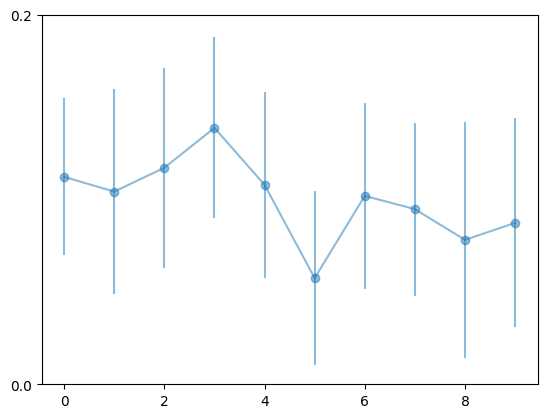

In [65]:
m0, v0 = prior_regression(100, distributions[3])
plt.errorbar(range(10), m0, fmt='-o', yerr=v0, alpha=0.5)
plt.ylim([0,0.2])
plt.yticks([0,0.2])

I was initially getting bad fits because I set up my mean parameters wrong, with the balanced dataset!